In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

In [3]:
projectName = 'colorectal_histology' 

dataset, info = tfds.load(projectName, split=f'train', as_supervised=True,with_info=True, shuffle_files=True)
dataset = dataset.shuffle(buffer_size=5000,reshuffle_each_iteration = False)
dataset = dataset.map(lambda img, lbl: (tf.cast(img, tf.float32) / 255.0, lbl))
print(f'dataset type {type(dataset)} with {len(dataset)} images') 
print(info.supervised_keys)
print(info.features.items())

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteG61NI9/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
dataset type <class 'tensorflow.python.data.ops.map_op._MapDataset'> with 5000 images
('image', 'label')
dict_items([('image', Image(shape=(150, 150, 3), dtype=uint8)), ('label', ClassLabel(shape=(), dtype=int64, num_classes=8)), ('filename', Text(shape=(), dtype=string))])


In [4]:
batch_size = 64

valid_data = dataset.take(1000)
valid_data = valid_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_data  = dataset.skip(1000).take(1000)
test_data  = test_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_data   = dataset.skip(2000).take(3000)
train_data = train_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [5]:
model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((150, 150, 3)),#input資料為150*150*3(RGB)
        tf.keras.layers.Conv2D(64, 5, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(8, activation=tf.keras.activations.softmax)
    ], name='cnn_model')


model.compile(optimizer='adam',loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['accuracy'])
print(model.summary())


Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 128)       73856     
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 128)      0 

In [6]:
#使用Callback，可以記錄訓練過程產生的資訊
logdir="logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)   
#用資料訓練10次模型，並將結果紀錄在hist中。
hist = model.fit(train_data, epochs=10,validation_data=valid_data,callbacks=[tensorboard_callback])

Epoch 1/10
47/47 [==============================] - 177s 4s/step - loss: 1.4928 - accuracy: 0.3493 - val_loss: 1.0179 - val_accuracy: 0.5570
Epoch 2/10
47/47 [==============================] - 174s 4s/step - loss: 1.0301 - accuracy: 0.5163 - val_loss: 1.0328 - val_accuracy: 0.4960
Epoch 3/10
47/47 [==============================] - 174s 4s/step - loss: 0.9634 - accuracy: 0.5627 - val_loss: 0.8384 - val_accuracy: 0.6060
Epoch 4/10
47/47 [==============================] - 174s 4s/step - loss: 0.8755 - accuracy: 0.6203 - val_loss: 0.7763 - val_accuracy: 0.6630
Epoch 5/10
47/47 [==============================] - 174s 4s/step - loss: 0.8472 - accuracy: 0.6440 - val_loss: 0.6877 - val_accuracy: 0.7340
Epoch 6/10
47/47 [==============================] - 174s 4s/step - loss: 0.8044 - accuracy: 0.6600 - val_loss: 0.8489 - val_accuracy: 0.5920
Epoch 7/10
47/47 [==============================] - 174s 4s/step - loss: 0.7138 - accuracy: 0.7083 - val_loss: 0.7060 - val_accuracy: 0.7480
Epoch 8/10
47

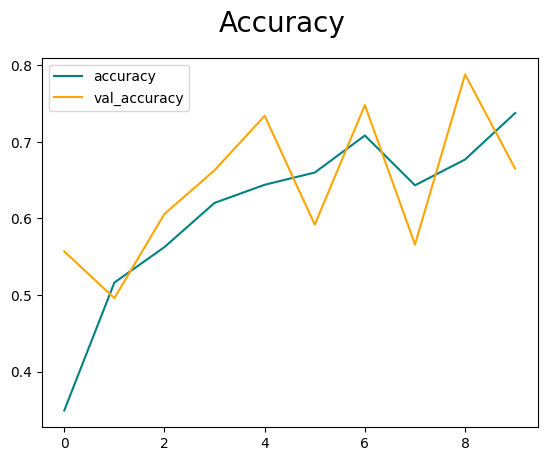

In [7]:
fig_accuracy = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig_accuracy.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [8]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy, AUC
from sklearn.metrics import classification_report
test_iterator = test_data.as_numpy_iterator()
test_batch = test_iterator.next()

pre = Precision()
re = Recall()
acc = Accuracy()
auc=AUC(num_thresholds=8)

test_accuracies=[]
test_recalls = []
test_precisions = []
test_aucs=[]
y_test=[]
y_pred=[]

for test_batch in test_iterator:
    image, label = test_batch
    yhat = model.predict(image)
    na = np.argmax(yhat,axis=1)
    y_test.append(label)
    y_pred.append(na)
    
    pre.update_state(label, na)
    re.update_state(label, na)
    acc.update_state(label, na)
    auc.update_state(label, na)    


y_test_flat = np.concatenate(y_test)
y_pred_flat = np.concatenate(y_pred)
print(classification_report(y_test_flat, y_pred_flat, target_names=['0','1','2','3','4','5','6','7']))
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}')
print()
print(f'Acccuracy:{acc.result().numpy()}, AUC:{auc.result().numpy()}')

2/2 [==============================] - 1s 83ms/step
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       126
           1       0.47      0.82      0.60       115
           2       0.65      0.53      0.58       110
           3       0.89      0.85      0.87       115
           4       0.64      0.54      0.59       120
           5       0.76      0.71      0.74       140
           6       0.65      0.34      0.44       101
           7       0.62      1.00      0.77       109

    accuracy                           0.68       936
   macro avg       0.71      0.68      0.67       936
weighted avg       0.72      0.68      0.67       936

Precision:0.9440559148788452, Recall:1.0

Acccuracy:0.6794871687889099, AUC:0.8095238208770752
